In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leaf-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1951218%2F3217030%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240408%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240408T050548Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf6cbb277b76c996ca6dbe713cdccfbf80dcf61dac3129774074b1bf319e1082359f7db649103544c6ac253dccf13bca418523d7d2eaf139562c0b4fa5159c177b73f24d1f6ebf0344e7bd8ae1457a9e54bb0cefcf0ae97aec9b1fcec8ce32b5d49b8e0ef4d36bbab3409fbfe2f9ed79ad0568ec22dacb221641d3068c30447f2242b2ae95c20b08198735b1010eb09f781887789b1a0412214b3fab4115fbe82c1990c506b9200b04baafaeffc74788bc15e91793539f0024ca2541d30c754b87491ce54cf54136a723bfd3a5fe02fc196b7361bfb577f2a1128533a84a804667ff1758dd97772d9470d1dede8689cb6a2f37b97b894ce7ba436cfaeb33b51d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 14105730 bytes downloaded
Downloaded and uncompressed: leaf-image-dataset
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical


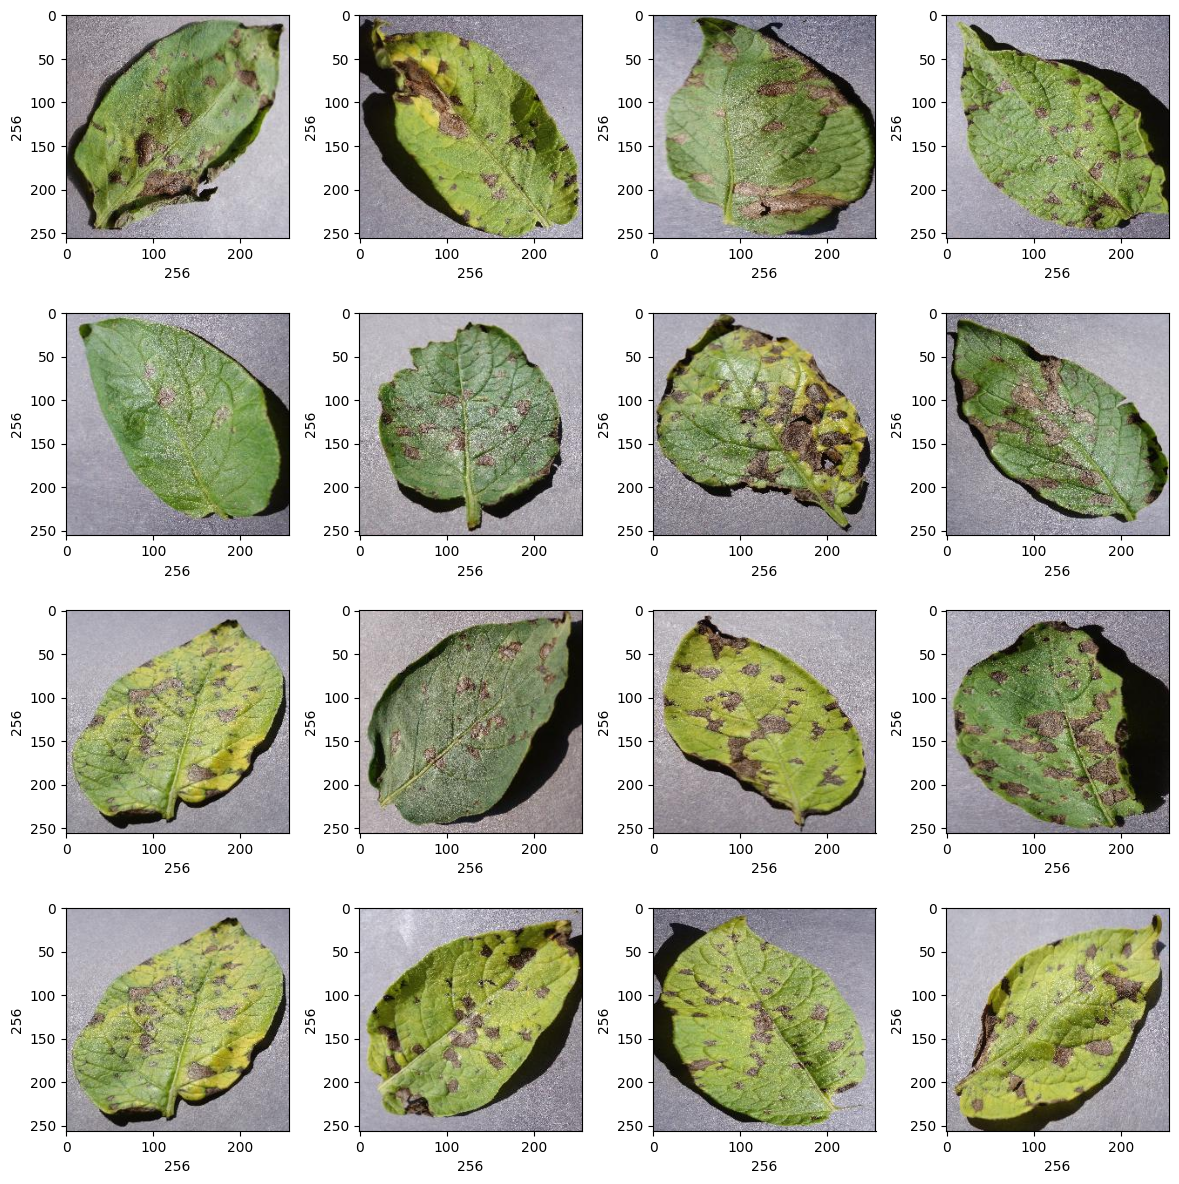

In [ ]:
# Plotting 12 images to check dataset
#Now we will observe some of the iamges that are their in our dataset. We will plot 12 images here using the matplotlib library.
plt.figure(figsize=(12,12))
path = "../input/leaf-image-dataset/Plant_images/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
dir = "../input/leaf-image-dataset/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
#Now we will convert all the images into numpy array.

for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])



Now we will convert all the images into numpy array.


In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

#it is a balanced dataset as you can see

0    300
1    300
2    300
Name: count, dtype: int64

In [ ]:
#Next we will observe the shape of the image.
image_list[0].shape

(256, 256, 3)

In [ ]:
#Checking the total number of the images which is the length of the labels list.
label_list = np.array(label_list)
label_list.shape

(900,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

In [ ]:
#Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

In [ ]:
#Next we will split the dataset into validation and training data.
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 50
batch_size = 128

# Define the checkpoint filepath
checkpoint_filepath = 'model_checkpoint.h5'

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_freq='epoch',  # Save every epoch
    verbose=1
)

# Fit the model with the ModelCheckpoint callback
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback]
)


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.0615 - accuracy: 0.4410
Epoch 1: saving model to model_checkpoint.h5
5/5 [==============================] - 33s 6s/step - loss: 1.0615 - accuracy: 0.4410 - val_loss: 1.0124 - val_accuracy: 0.5139
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.6059
Epoch 2: saving model to model_checkpoint.h5
5/5 [==============================] - 29s 6s/step - loss: 0.9687 - accuracy: 0.6059 - val_loss: 0.9573 - val_accuracy: 0.5486
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.9155 - accuracy: 0.6128
Epoch 3: saving model to model_checkpoint.h5
5/5 [==============================] - 30s 6s/step - loss: 0.9155 - accuracy: 0.6128 - val_loss: 0.9177 - val_accuracy: 0.5417
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.8674 - accuracy: 0.6163
Epoch 4: saving model to model_checkpoint.h5
5/5 [==============================] - 33s 7s/step - loss: 0.8674 - accuracy: 0.6163 - val_loss: 0.8697 - val_accuracy: 0.5694
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.6233
Epoch 5: saving model to model_checkpoint.h5
5/5 [==============================] - 30s 6s/step - loss: 0.8231 - accuracy: 0.62

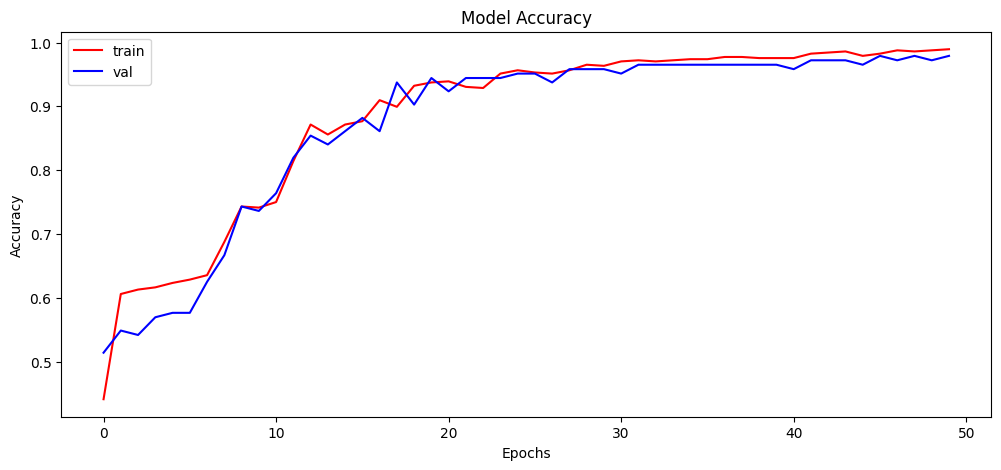

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 3s 445ms/step - loss: 0.4114 - accuracy: 0.9722
Test Accuracy: 97.22222089767456


In [ ]:
y_pred = model.predict(x_test)

6/6 [==============================] - 5s 686ms/step


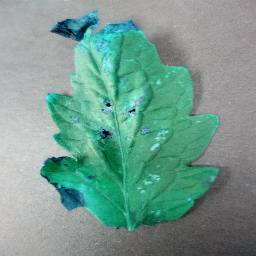

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [ ]:
# Find the index of the max value in y_test[10] and y_pred[10]
true_label_index = np.argmax(y_test[10])
predicted_label_index = np.argmax(y_pred[10])

# Get the corresponding labels
true_label = all_labels[true_label_index]
predicted_label = all_labels[predicted_label_index]

# Check if the prediction is correct
is_correct = true_label == predicted_label

# Print the result
print("True Label: ", true_label)
print("Predicted Label: ", predicted_label)
print("Prediction Correct? ", is_correct)


True Label:  Potato-Early_blight
Predicted Label:  Potato-Early_blight
Prediction Correct?  True
